In [1]:
import numpy as np
import scipy.io       # To import data from .mat file
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [2]:
import json

In [3]:
import sys,os
sys.path.append(r'../..')
import parameter_optimization.src.degradation_functions as dfunc

In [4]:
%run ../../degradation_model/src/simulation_model.py

In [5]:
def cap_loss(data_caploss, data_expdata,params,x,plot=False):
    cap_loss_exp = data_caploss['Cap Loss'].values
    modeldf=pd.DataFrame()
    modeldf[time_col] = data_expdata["Time [Hr]"]
    modeldf[soc_col] = data_expdata["SOC"]
    modeldf[temp_col] =  data_expdata["Temp"] - 273.15
    modeldf[current_col] = data_expdata["I"]
    params['k_cyc_highT_ref'] = x[0]
    params['Ea_cyc_highT'] = x[1]
    params["k_cyc_lowT_ref"] =x[2]
    params["Ea_cyc_lowT"] =x[3]
    params["beta_lowT"] =x[4]
    params["k_cyc_lowT_highSOC_ref"] =x[5]
    params["Ea_cyc_lowT_highSOC"] =x[6]
    params["beta_lowT_highSOC"] =x[7]
 
    model = DegradationModelECS2018(
        TestInputs(params, modeldf),
        "temp",
        None)
    model.run()
    cycle_index = data_expdata.cycle_index
    change_cycle = np.ediff1d(cycle_index.values,to_end=0.0) > 0.99
    model_loss = 100 * model.Q_tot[change_cycle]
        
    len_exp_data = len(cap_loss_exp)
    if sum(change_cycle) > len_exp_data:
        model_loss = model_loss[-1*len_exp_data:]
    if plot:
        fig,axes = plt.subplots()
        axes.plot(model_loss, label='model')
        axes.plot(cap_loss_exp, label='exp')
        print(f"model: {model_loss[-1]}, exp: {cap_loss_exp[-1]}")
    return np.sqrt(np.mean(np.square(model_loss - cap_loss_exp)))

In [6]:
def read_data(flocation, fnames):
    with open( "../data/b0_sample/processed/EVA2_B0sample.json" ) as f:
        parameters = json.load(f)
    df_list = []
    for fn in fnames:
        data_caploss = pd.read_csv(flocation + fn + "_caploss.csv")
        data_expdata = pd.read_csv(flocation + fn + "_expdata.csv")
        df_list.append(dict(caploss=data_caploss, expdata=data_expdata))
    inp_dict = dict(params=parameters, data=df_list)
    return inp_dict 

In [7]:
pd.read_csv('../data/b0_sample/cal_params_fitted.csv').iloc[0].to_dict()

{'k_cal_ref': 1.55530439504276e-05,
 'Ea_cal': 63491.64212574216,
 'alpha': 1.8897709667457852,
 'k0': 2.0986397079981054}

In [8]:
class TestInputs:
    
    def __init__(self,cell_parameters, simulation_period_df ):
        self.cell_parameters = cell_parameters
        self.simulation_period_df = simulation_period_df
        self.input_config = dict( lowT_high_SOC_parameter_modifier=1)

In [9]:
#%% Error function
def error(x):  
#     params = pd.read_csv('../data/cal_params_fitted.csv')
    params = inputdict['params']
    error = np.zeros(n_test_conditions)
    for i in range(n_test_conditions):
        datadict = inputdict['data'][i]
        data_caploss = datadict['caploss'] 
        data_expdata = datadict['expdata']
        if make_plots:
            print(f'{file_names[i]}')
        error[i] = cap_loss(data_caploss,data_expdata,params,x,make_plots) 
        # make plots is to change whether to plot or not
        
    error_tot = np.sum(error)
    return error_tot

In [10]:
file_dirc = '../data/b0_sample/processed/'
file_names = """172
310 0.33C 25deg
383 1C 25deg
412
432 0.33C 25deg
434 1c 25deg
500
507
HA212_00058__1-11-3-P73B__45oC__Cby3__2.75-4.20__20180615171240
HA212_00109__1-11-4-P73B__45oC__Cby3__2.75-4.20__20180615171320""".split('\n')

In [11]:
n_test_conditions = len(file_names)
# n_test_conditions = 1 
inputdict = read_data(file_dirc, file_names)
time_col, soc_col, temp_col, current_col=  ("Time [hr]", "SOC []", "temp", "Current [A]")

In [12]:
order =  """k_cyc_highT_ref
            Ea_cyc_highT
            k_cyc_lowT_ref
            Ea_cyc_lowT
            beta_lowT
            k_cyc_lowT_highSOC_ref
            Ea_cyc_lowT_highSOC
            beta_lowT_highSOC
""".split()
x0 = [] 
for i,k in enumerate(order):
    x0.append( inputdict['params'][k])
x0

[9.82e-05, 33700.0, 0.000301, -55500.0, 2.64, 2.03e-06, -233000.0, 7.84]

172
<class 'numpy.ndarray'>
model: 17.377064369352894, exp: 8.101044065497815
310 0.33C 25deg
<class 'numpy.ndarray'>
model: 2.0732041714876353, exp: 2.580259166236792
383 1C 25deg
<class 'numpy.ndarray'>
model: 5.6940951382714236, exp: 9.359562138033436
412
<class 'numpy.ndarray'>
model: 20.153542453854552, exp: 26.361719483477753
432 0.33C 25deg
<class 'numpy.ndarray'>
model: 2.8558272974712104, exp: 2.8285819156453966
434 1c 25deg
<class 'numpy.ndarray'>
model: 6.590073094067081, exp: 11.750871627456705
500
<class 'numpy.ndarray'>
model: 14.28381915338131, exp: 9.1640731041858
507
<class 'numpy.ndarray'>
model: 63.22258385247497, exp: 38.504098999407745
HA212_00058__1-11-3-P73B__45oC__Cby3__2.75-4.20__20180615171240
<class 'numpy.ndarray'>
model: 4.671985231207019, exp: 5.06425873081
HA212_00109__1-11-4-P73B__45oC__Cby3__2.75-4.20__20180615171320
<class 'numpy.ndarray'>
model: 4.700419491932983, exp: 4.78322213859


40.21311587915643

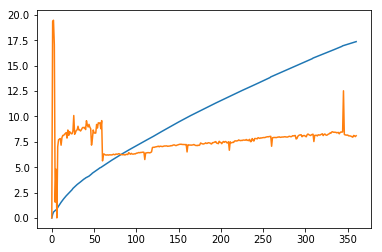

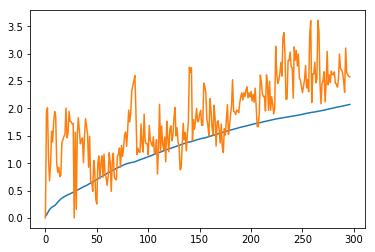

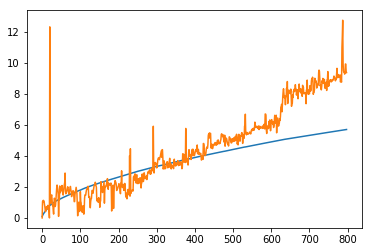

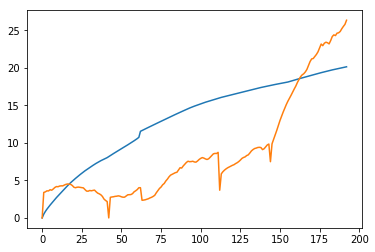

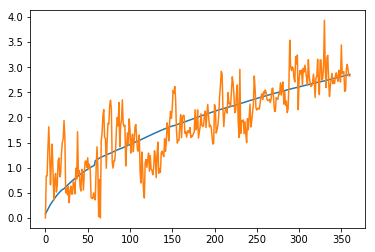

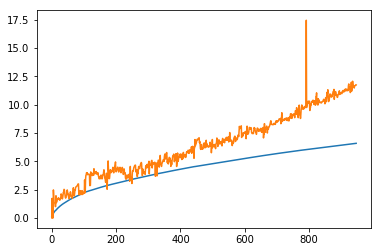

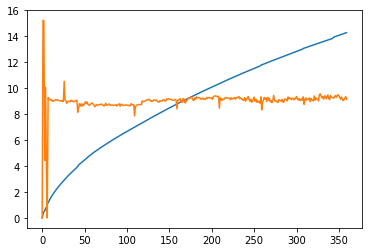

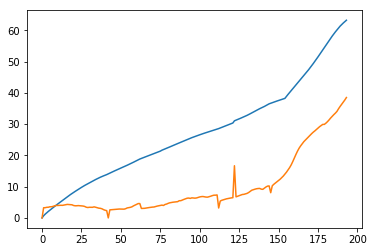

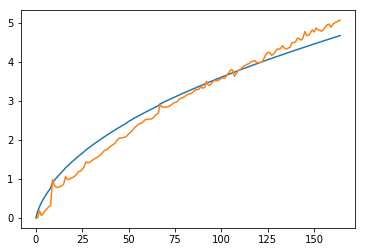

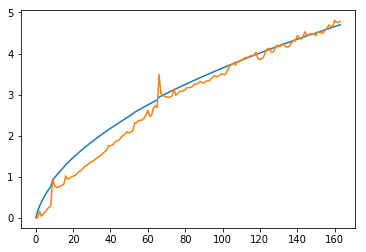

In [13]:
make_plots = True
error(x0)
# error(xf_cycle)

In [14]:
start = timeit.default_timer()
make_plots = False
xf_cycle = opt.fmin(error,x0)

stop = timeit.default_timer()
print(stop - start)
print(xf_cycle)

30581.773525598
[ 1.39170214e-04  2.12235454e+04  5.01739902e-04 -1.89393667e+04
  5.38552992e-01  2.42299619e-07 -3.65507305e+05  1.82249231e+01]


Optimization terminated successfully.
         Current function value: 3.184281
         Iterations: 62
         Function evaluations: 126